In [1]:
# import libraries
import numpy as np
import pandas as pd
import random
import csv
import scipy.stats as stats
import seaborn as sns
from collections import Counter
from collections import defaultdict
import math
from sklearn.linear_model import ElasticNet
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from random import randint
from sklearn.linear_model import Ridge
from sklearn import linear_model

import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric import smoothers_lowess
from pandas import Series, DataFrame
from patsy import dmatrices
from sklearn import datasets, svm

# initialize the plotting sizes
# set size
plt.rc('figure', figsize=(15, 8))
# subplots size
fizsize_with_subplots = (15, 8)
# histogram size
bin_size = 10

In [2]:
# Loading data
dates = pd.read_csv('data/dates.csv',header=None)
queries = pd.read_csv('data/queries.csv',header=None)
X = pd.read_csv('data/X.csv',header=None)
y = pd.read_csv('data/y.csv',header=None)

X.columns = queries

In [3]:
# data preprocessing and train-test split
# this data is well formed with no missing value and other symbols or labels that are non numerical.
# splitting the data into train and test

# Here we want the first 500 queries
X = X.iloc[:, 0: 500]

# first with the last year as test
# for convinience, pick the two validation set starting from 1/3 and 2/3 of the training set,
# 10% of training set as validation, here use 400 data points, two 200 periods.
test_size =365
length = X.shape[0]
l =(X.shape[0]-test_size)//3

train1_X = pd.concat([X[0:l],X[l+200:2*l],X[2*l+200:length-test_size]])
val1_X = pd.concat([X[l:l+200],X[2*l:2*l+200]])
train1_y = pd.concat([y[0:l],y[l+200:2*l],y[2*l+200:length-test_size]])
val1_y = pd.concat([y[l:l+200],y[2*l:2*l+200]])
test1_X = X[length-test_size:]
test1_y = y[length-test_size:]

# second with the last 2 year as test
test_size2 =365*2
l2 =(X.shape[0]-test_size2)//3

train2_X = pd.concat([X[0:l2],X[l2+180:2*l2],X[2*l2+180:length-test_size2]])
val2_X = pd.concat([X[l2:l2+180],X[2*l2:2*l2+180]])
train2_y = pd.concat([y[0:l2],y[l2+180:2*l2],y[2*l2+180:length-test_size2]])
val2_y = pd.concat([y[l2:l2+180],y[2*l2:2*l2+180]])
test2_X = X[length-test_size2:length-test_size]
test2_y = y[length-test_size2:length-test_size]

print('X shape: ',X.shape,'  y shape: ',y.shape)
print('train1 X:',train1_X.shape,' train1 y:',train1_y.shape,' Test1 X shape:',test1_X.shape, ' Test1 y shape:',test1_y.shape)
print('validation1 X:',val1_X.shape,' validation1 y:',val1_y.shape)
print('train2 X:',train2_X.shape,' train2 y:',train2_y.shape,' Test2 X:',test2_X.shape,' Test2 y:',test2_y.shape)
print('validation2 X:',val2_X.shape,' validation2 y:',val2_y.shape)

X shape:  (4383, 500)   y shape:  (4383, 1)
train1 X: (3618, 500)  train1 y: (3618, 1)  Test1 X shape: (365, 500)  Test1 y shape: (365, 1)
validation1 X: (400, 500)  validation1 y: (400, 1)
train2 X: (3293, 500)  train2 y: (3293, 1)  Test2 X: (365, 500)  Test2 y: (365, 1)
validation2 X: (360, 500)  validation2 y: (360, 1)


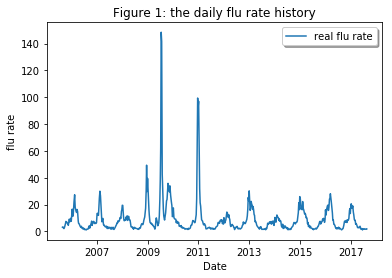

In [8]:

# visualize
date = pd.date_range('20050824',periods=4383)
import matplotlib.dates as mdates
df = y.copy()
df['y'] = y.values

fig, ax = plt.subplots()
ax.plot(date,df.y,label='real flu rate')

# Now add the legend with some customizations.
legend = ax.legend(loc='upper right', shadow=True)
plt.title("Figure 1: the daily flu rate history")
plt.ylabel('flu rate')
plt.xlabel('Date')

plt.savefig("Flu_Rate.pdf", bbox_inches='tight')

plt.show()

In [4]:
train_size = train1_X.shape[0]
corrs = np.zeros((X.shape[1],1))
for i in range(0,X.shape[1]):
    if X.sum(axis=1)[i] == 0:
        corrs[i] = 0
    else:
        corrs[i] = np.corrcoef(train1_X.iloc[0:train_size,i],train1_y.iloc[0:train_size,0])[0,1]
        
corrs.shape,X.columns.shape,X.columns[0],X.columns[499]

((500, 1), (500,), ('flu',), ('symptoms of kidney infection',))

In [5]:
def corr_filter(df_X,df_Xval,df_Xtest,corrs,threshold):
    X = df_X.copy()
    X_test = df_Xtest.copy()
    X_val = df_Xval.copy()
    col_corr = set() # Set of all the names of deleted columns
    for i in range(0,500):
            if corrs[i,0] < threshold: 
                #print(X.columns[i])
                colname = df_X.columns[i]
                del X[colname] # deleting the column from the dataset
                del X_test[colname] 
                del X_val[colname]

    return X,X_val,X_test

## Fixing pearson correlation filter r>=0.2

In [6]:
#train1_X0,test1_X0 = corr_filter(train1_X,test1_X,corrs,0.1)
train1_X1,val1_X1,test1_X1 = corr_filter(train1_X,val1_X,test1_X,corrs,0.2)
#train1_X2,test1_X2 = corr_filter(train1_X,test1_X,corrs,0.3)
#train1_X3,test1_X3 = corr_filter(train1_X,test1_X,corrs,0.4)

In [7]:
#print('For correlation filter r>=0.1, we select feature number: ',train1_X0.shape[1])
print('For correlation filter r>=0.2, we select feature number: ',train1_X1.shape[1])
#print('For correlation filter r>=0.3, we select feature number: ',train1_X2.shape[1])
#print('For correlation filter r>=0.4, we select feature number: ',train1_X3.shape[1])

For correlation filter r>=0.2, we select feature number:  212


In [8]:
# Defien the mearure matrics, MAE, RMSE, CORR
# define three metrics: mean absolute error, root mean squared error and Pearson's correlation.
from sklearn.metrics import mean_absolute_error
# mae = mean_absolute_error(y_actual, y_pred)

from sklearn.metrics import mean_squared_error
from math import sqrt
# rmse = sqrt(mean_squared_error(y_actual, y_pred))

# np.correcoef returns Pearson product-moment correlation coefficients
def pearson_r(x,y):   
    corr_mat = np.corrcoef(x,y)
    return corr_mat[0,1]
# r = pearson_r(y_actual,y_pred)


# Generalise the function for convinient tuning
def ridge(a,train_X,train_y,test_X,test_y):
    # scaling and modeling
    scalerX = StandardScaler()
    scalerX.fit(train_X)
    train_X = scalerX.transform(train_X)
    test_X = scalerX.transform(test_X)
    
    scalery = StandardScaler() 
    scalery.fit(train_y) 
    train_y = scalery.transform(train_y) 
    
    
    alpha=a
    ri = Ridge(alpha, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)
  
    ri.fit(train_X,train_y)

    y_pred1 = ri.predict(test_X)
    y_pred1 = scalery.inverse_transform(y_pred1)

    mae1 = mean_absolute_error(test_y, y_pred1)
    #print('The mean absolute error is: ',mae1)

    rmse1 = sqrt(mean_squared_error(test_y, y_pred1))
    #print('The root mean squared error is: ',rmse1)
    
    corr_y = test_y.copy()
    corr_y['y_act'] = test_y
    corr_y['y_pred']= y_pred1
    corr = np.corrcoef(corr_y['y_act'],corr_y['y_pred'])[0,1]
    #print('The correlation is: ',corr)
    
    return rmse1, mae1,corr
    


# scaling and modeling
scaler = MinMaxScaler()
train1_X0_scaled = scaler.fit_transform(train1_X0)
test1_X0_scaled = scaler.transform(test1_x0)

train1_X1_scaled = scaler.fit_transform(train1_X1)
test1_X1_scaled = scaler.transform(test1_x1)

train1_X2_scaled = scaler.fit_transform(train1_X2)
test1_X2_scaled = scaler.transform(test1_x2)

train1_X3_scaled = scaler.fit_transform(train1_X3)
test1_X3_scaled = scaler.transform(test1_x3)


para = [10]
para_l=[0.3]
print('For correlation filter r>=0.1, 310 features are selected')
for a in para:
    for l in para_l:
        print('alpha:',a,' L1-ratio:',l)
        print(eNet(a,l,train1_X0,train1_y,test1_X0,test1_y))

In [9]:
print(train1_X1.shape,val1_X1.shape)
train3_X = train1_X1.append(val1_X1)
train3_y = train1_y.append(val1_y)
train3_X.shape,train3_y.shape

(3618, 212) (400, 212)


((4018, 212), (4018, 1))

In [10]:

para = np.arange(0.01, 3000000, 10000)
rmse=100000
mae=1000000
corr=0
for a in para:
    print('alpha:',a)
    rmse0,mae0,corr0 = ridge(a,train1_X1,train1_y,val1_X1,val1_y)
    if rmse0< rmse:
        rmse=rmse0
        mae=mae0
        corr = corr0
        print('========================================')
        print('Best RMSE is updated! ' )
        print('The mean absolute error is: ',mae)
        print('The root mean squared error is: ',rmse)
        print('The correlation is: ',corr)
        print('----------------------------------------')
        

alpha: 0.01
Best RMSE is updated! 
The mean absolute error is:  23.975807792367778
The root mean squared error is:  49.250694810847634
The correlation is:  0.7356980749701838
----------------------------------------
alpha: 10000.01
Best RMSE is updated! 
The mean absolute error is:  18.406609997952764
The root mean squared error is:  35.657537794343824
The correlation is:  0.8040287657637935
----------------------------------------
alpha: 20000.01
Best RMSE is updated! 
The mean absolute error is:  15.914786092284343
The root mean squared error is:  30.475230663174955
The correlation is:  0.7991885890281298
----------------------------------------
alpha: 30000.01
Best RMSE is updated! 
The mean absolute error is:  14.253093316360847
The root mean squared error is:  27.193153076135307
The correlation is:  0.7954314332155613
----------------------------------------
alpha: 40000.01
Best RMSE is updated! 
The mean absolute error is:  13.073717287718445
The root mean squared error is:  24.8

alpha: 1840000.01
alpha: 1850000.01
alpha: 1860000.01
alpha: 1870000.01
alpha: 1880000.01
alpha: 1890000.01
alpha: 1900000.01
alpha: 1910000.01
alpha: 1920000.01
alpha: 1930000.01
alpha: 1940000.01
alpha: 1950000.01
alpha: 1960000.01
alpha: 1970000.01
alpha: 1980000.01
alpha: 1990000.01
alpha: 2000000.01
alpha: 2010000.01
alpha: 2020000.01
alpha: 2030000.01
alpha: 2040000.01
alpha: 2050000.01
alpha: 2060000.01
alpha: 2070000.01
alpha: 2080000.01
alpha: 2090000.01
alpha: 2100000.01
alpha: 2110000.01
alpha: 2120000.01
alpha: 2130000.01
alpha: 2140000.01
alpha: 2150000.01
alpha: 2160000.01
alpha: 2170000.01
alpha: 2180000.01
alpha: 2190000.01
alpha: 2200000.01
alpha: 2210000.01
alpha: 2220000.01
alpha: 2230000.01
alpha: 2240000.01
alpha: 2250000.01
alpha: 2260000.01
alpha: 2270000.01
alpha: 2280000.01
alpha: 2290000.01
alpha: 2300000.01
alpha: 2310000.01
alpha: 2320000.01
alpha: 2330000.01
alpha: 2340000.01
alpha: 2350000.01
alpha: 2360000.01
alpha: 2370000.01
alpha: 2380000.01
alpha: 239

para = [10]
para_l=[0.3]
print('For correlation filter r>=0.3, 150 features are selected')
for a in para:
    for l in para_l:
        print('alpha:',a,' L1-ratio:',l)
        print(eNet(a,l,train1_X2,train1_y,test1_X2,test1_y))

para = [10]
para_l=[0.3]
print('For correlation filter r>=0.4, 103 features are selected')
for a in para:
    for l in para_l:
        print('alpha:',a,' L1-ratio:',l)
        print(eNet(a,l,train1_X3,train1_y,test1_X3,test1_y))

In [15]:
para =[200000,0]
rmse=100000
mae=1000000
corr=0
for a in para:
    print('alpha:',a)
    rmse0,mae0,corr0 = ridge(a,train3_X,train3_y,test1_X1,test1_y)
    if rmse0< rmse:
        rmse=rmse0
        mae=mae0
        corr = corr0
        print('========================================')
        print('Best RMSE is updated! ' )
        print('The mean absolute error is: ',mae)
        print('The root mean squared error is: ',rmse)
        print('The correlation is: ',corr)
        print('----------------------------------------')

alpha: 200000
Best RMSE is updated! 
The mean absolute error is:  4.599519526164512
The root mean squared error is:  4.950442142540025
The correlation is:  0.7624009492801067
----------------------------------------
alpha: 0
Best RMSE is updated! 
The mean absolute error is:  2.6913576648695963
The root mean squared error is:  3.379886907837201
The correlation is:  0.9107676241156444
----------------------------------------


In [16]:
alpha=200000 
ri = Ridge(alpha, copy_X=True, fit_intercept=True, max_iter=None,
  normalize=False, random_state=None, solver='auto', tol=0.001)

ri.fit(train3_X,train3_y)

y_pred1 = ri.predict(test1_X1)

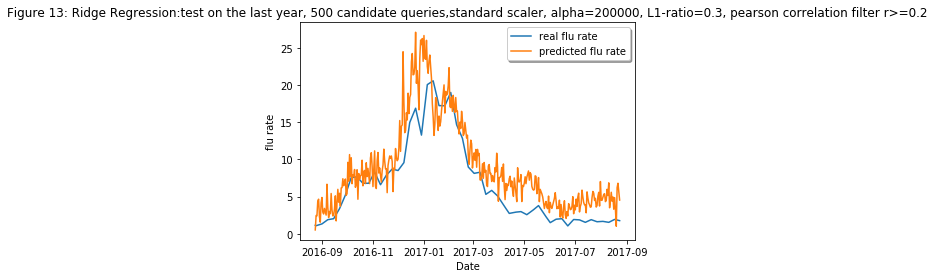

In [18]:
# visualize
date = pd.date_range('20050824',periods=4383)
import matplotlib.dates as mdates
df = y.copy()
df['y'] = y.values

fig, ax = plt.subplots()
ax.plot(date[4018:],df.y[4018:],label='real flu rate')
ax.plot(date[4018:],y_pred1,label='predicted flu rate')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper right', shadow=True)
plt.title("Figure 13: Ridge Regression:test on the last year, 500 candidate queries,standard scaler, alpha=200000, L1-ratio=0.3, pearson correlation filter r>=0.2")
plt.ylabel('flu rate')
plt.xlabel('Date')

plt.show()

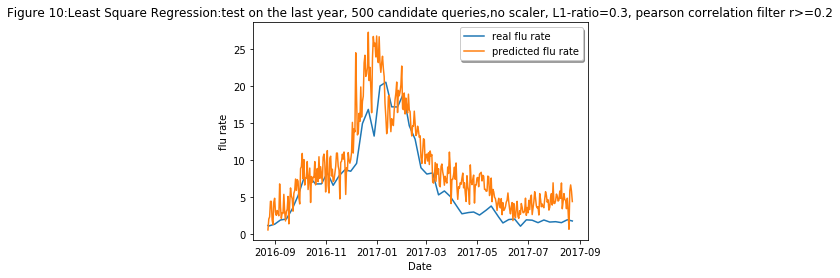

In [19]:
alpha=0
ri = Ridge(alpha, copy_X=True, fit_intercept=True, max_iter=None,
  normalize=False, random_state=None, solver='auto', tol=0.001)

ri.fit(train3_X,train3_y)

y_pred1 = ri.predict(test1_X1)

# visualize
date = pd.date_range('20050824',periods=4383)
import matplotlib.dates as mdates
df = y.copy()
df['y'] = y.values

fig, ax = plt.subplots()
ax.plot(date[4018:],df.y[4018:],label='real flu rate')
ax.plot(date[4018:],y_pred1,label='predicted flu rate')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper right', shadow=True)
plt.title("Figure 10:Least Square Regression:test on the last year, 500 candidate queries,no scaler, L1-ratio=0.3, pearson correlation filter r>=0.2")
plt.ylabel('flu rate')
plt.xlabel('Date')

plt.show()

## For the last 2 years as the testing set

In [20]:
train_size2 = train2_X.shape[0]
corrs2 = np.zeros((X.shape[1],1))
for i in range(0,X.shape[1]):
    if X.sum(axis=1)[i] == 0:
        corrs2[i] = 0
    else:
        corrs2[i] = np.corrcoef(train2_X.iloc[0:train_size2,i],train2_y.iloc[0:train_size2,0])[0,1]
        
corrs2.shape,X.columns.shape,X.columns[0],X.columns[499]

((500, 1), (500,), ('flu',), ('symptoms of kidney infection',))

In [21]:
#train2_X0,test2_X0 = corr_filter(train2_X,test2_X,corrs2,0.1)
train2_X1,val2_X1,test2_X1 = corr_filter(train2_X,val2_X,test2_X,corrs2,0.2)
#train2_X2,test2_X2 = corr_filter(train2_X,test2_X,corrs2,0.3)
#train2_X3,test2_X3 = corr_filter(train2_X,test2_X,corrs2,0.4)

In [22]:
#print('For correlation filter r>0.1, we select feature number: ',train2_X0.shape[1])
print('For correlation filter r>0.2, we select feature number: ',train2_X1.shape[1])
#print('For correlation filter r>0.3, we select feature number: ',train2_X2.shape[1])
#print('For correlation filter r>0.4, we select feature number: ',train2_X3.shape[1])

For correlation filter r>0.2, we select feature number:  222


# scaling and modeling
scaler = MinMaxScaler()
train2_X0_scaled = scaler.fit_transform(train2_X0)
test2_X0_scaled = scaler.transform(test2_X0)

train2_X1_scaled = scaler.fit_transform(train2_X1)
test2_X1_scaled = scaler.transform(test2_X1)

train2_X2_scaled = scaler.fit_transform(train2_X2)
test2_X2_scaled = scaler.transform(test2_X2)

train2_X3_scaled = scaler.fit_transform(train2_X3)
test2_X3_scaled = scaler.transform(test2_X3)


para = range(1,100)
para = np.arange(0.01, 10.0, 0.01)
rmse=100000
mae=1000000
corr=0
for a in para:
    print('alpha:',a)
    rmse0,mae0,corr0 = ridge(a,train1_X1,train1_y,val1_X1,val1_y)
    if rmse0< rmse:
        rmse=rmse0
        mae=mae0
        corr = corr0
        print('========================================')
        print('Best RMSE is updated! ' )
        print('The mean absolute error is: ',mae)
        print('The root mean squared error is: ',rmse)
        print('The correlation is: ',corr)
        print('----------------------------------------')

In [23]:
print(train2_X1.shape,val2_X1.shape)
train4_X = train2_X1.append(val2_X1)
train4_y = train2_y.append(val2_y)
train4_X.shape,train4_y.shape

(3293, 222) (360, 222)


((3653, 222), (3653, 1))

In [25]:

para =np.arange(0, 20000000, 10000)
rmse=100000
mae=1000000
corr=0
for a in para:
    print('alpha:',a)
    rmse0,mae0,corr0 = ridge(a,train2_X1,train2_y,val2_X1,val2_y)
    if rmse0< rmse:
        rmse=rmse0
        mae=mae0
        corr = corr0
        print('========================================')
        print('Best RMSE is updated! ' )
        print('The mean absolute error is: ',mae)
        print('The root mean squared error is: ',rmse)
        print('The correlation is: ',corr)
        print('----------------------------------------')

alpha: 0
Best RMSE is updated! 
The mean absolute error is:  5.250710339696306
The root mean squared error is:  12.120662062934429
The correlation is:  0.34841490724443824
----------------------------------------
alpha: 10000
alpha: 20000
alpha: 30000
alpha: 40000
alpha: 50000
alpha: 60000
alpha: 70000
alpha: 80000
alpha: 90000
alpha: 100000
alpha: 110000
alpha: 120000
alpha: 130000
alpha: 140000
alpha: 150000
alpha: 160000
alpha: 170000
alpha: 180000
alpha: 190000
alpha: 200000
alpha: 210000
alpha: 220000
alpha: 230000
alpha: 240000
alpha: 250000
alpha: 260000
alpha: 270000
alpha: 280000
alpha: 290000
Best RMSE is updated! 
The mean absolute error is:  7.463203938519249
The root mean squared error is:  12.109130647760244
The correlation is:  0.10456194657504408
----------------------------------------
alpha: 300000
Best RMSE is updated! 
The mean absolute error is:  7.444538635248336
The root mean squared error is:  11.983609589575545
The correlation is:  0.10437459439779778
---------

Best RMSE is updated! 
The mean absolute error is:  7.081688822698668
The root mean squared error is:  9.869767590312403
The correlation is:  0.10163409961143466
----------------------------------------
alpha: 600000
Best RMSE is updated! 
The mean absolute error is:  7.0734572077631634
The root mean squared error is:  9.829034692840025
The correlation is:  0.10158565460314582
----------------------------------------
alpha: 610000
Best RMSE is updated! 
The mean absolute error is:  7.065406395782504
The root mean squared error is:  9.789587598172659
The correlation is:  0.10153875783199408
----------------------------------------
alpha: 620000
Best RMSE is updated! 
The mean absolute error is:  7.0575306861989775
The root mean squared error is:  9.7513747383986
The correlation is:  0.10149333621800578
----------------------------------------
alpha: 630000
Best RMSE is updated! 
The mean absolute error is:  7.049824603256753
The root mean squared error is:  9.714347040449097
The correla

Best RMSE is updated! 
The mean absolute error is:  6.881866199983459
The root mean squared error is:  8.983562015438737
The correlation is:  0.10056161486694802
----------------------------------------
alpha: 940000
Best RMSE is updated! 
The mean absolute error is:  6.877686479713968
The root mean squared error is:  8.967875758069466
The correlation is:  0.10054161981843225
----------------------------------------
alpha: 950000
Best RMSE is updated! 
The mean absolute error is:  6.873574594409712
The root mean squared error is:  8.952569145661245
The correlation is:  0.10052203871192575
----------------------------------------
alpha: 960000
Best RMSE is updated! 
The mean absolute error is:  6.8695289226775405
The root mean squared error is:  8.937630456794007
The correlation is:  0.10050285882272536
----------------------------------------
alpha: 970000
Best RMSE is updated! 
The mean absolute error is:  6.865547893701002
The root mean squared error is:  8.923048408999868
The correl

Best RMSE is updated! 
The mean absolute error is:  6.770406402227885
The root mean squared error is:  8.60912547415804
The correlation is:  0.10005621821683612
----------------------------------------
alpha: 1280000
Best RMSE is updated! 
The mean absolute error is:  6.767890771840929
The root mean squared error is:  8.601715468491488
The correlation is:  0.10004536746224583
----------------------------------------
alpha: 1290000
Best RMSE is updated! 
The mean absolute error is:  6.765407277132097
The root mean squared error is:  8.594450824550645
The correlation is:  0.10003468284859585
----------------------------------------
alpha: 1300000
Best RMSE is updated! 
The mean absolute error is:  6.762955309248223
The root mean squared error is:  8.587327903960217
The correlation is:  0.10002416058873502
----------------------------------------
alpha: 1310000
Best RMSE is updated! 
The mean absolute error is:  6.76053427452891
The root mean squared error is:  8.580343179144117
The corre

Best RMSE is updated! 
The mean absolute error is:  6.699853779356499
The root mean squared error is:  8.421180640005376
The correlation is:  0.09976215595235192
----------------------------------------
alpha: 1620000
Best RMSE is updated! 
The mean absolute error is:  6.698162357418884
The root mean squared error is:  8.417187837173325
The correlation is:  0.09975535708003219
----------------------------------------
alpha: 1630000
Best RMSE is updated! 
The mean absolute error is:  6.696488723863302
The root mean squared error is:  8.413260997239993
The correlation is:  0.09974864080409587
----------------------------------------
alpha: 1640000
Best RMSE is updated! 
The mean absolute error is:  6.694832600335707
The root mean squared error is:  8.40939873339272
The correlation is:  0.09974200562840405
----------------------------------------
alpha: 1650000
Best RMSE is updated! 
The mean absolute error is:  6.693193714240403
The root mean squared error is:  8.405599694340657
The corr

Best RMSE is updated! 
The mean absolute error is:  6.650890328604213
The root mean squared error is:  8.315524179727209
The correlation is:  0.09956978958823079
----------------------------------------
alpha: 1960000
Best RMSE is updated! 
The mean absolute error is:  6.649676236880845
The root mean squared error is:  8.313167654915736
The correlation is:  0.0995651337379171
----------------------------------------
alpha: 1970000
Best RMSE is updated! 
The mean absolute error is:  6.6484729885206875
The root mean squared error is:  8.310844846335991
The correlation is:  0.09956052476630783
----------------------------------------
alpha: 1980000
Best RMSE is updated! 
The mean absolute error is:  6.647309359937809
The root mean squared error is:  8.30855514288757
The correlation is:  0.0995559619689043
----------------------------------------
alpha: 1990000
Best RMSE is updated! 
The mean absolute error is:  6.64617614566989
The root mean squared error is:  8.30629794696485
The correla

Best RMSE is updated! 
The mean absolute error is:  6.609566242862846
The root mean squared error is:  8.23982291800764
The correlation is:  0.09940784064281213
----------------------------------------
alpha: 2380000
Best RMSE is updated! 
The mean absolute error is:  6.608753973008136
The root mean squared error is:  8.238479299151155
The correlation is:  0.09940467661646916
----------------------------------------
alpha: 2390000
Best RMSE is updated! 
The mean absolute error is:  6.607947813466707
The root mean squared error is:  8.237152248544998
The correlation is:  0.09940153888708025
----------------------------------------
alpha: 2400000
Best RMSE is updated! 
The mean absolute error is:  6.607147695635798
The root mean squared error is:  8.235841509359192
The correlation is:  0.09939842712815315
----------------------------------------
alpha: 2410000
Best RMSE is updated! 
The mean absolute error is:  6.606353551934364
The root mean squared error is:  8.234546829608588
The corr

Best RMSE is updated! 
The mean absolute error is:  6.585651025821288
The root mean squared error is:  8.203005679095716
The correlation is:  0.09931572796494115
----------------------------------------
alpha: 2710000
Best RMSE is updated! 
The mean absolute error is:  6.585009062876252
The root mean squared error is:  8.202095804641921
The correlation is:  0.09931328476450375
----------------------------------------
alpha: 2720000
Best RMSE is updated! 
The mean absolute error is:  6.5843713974623075
The root mean squared error is:  8.201196089432589
The correlation is:  0.09931085942106202
----------------------------------------
alpha: 2730000
Best RMSE is updated! 
The mean absolute error is:  6.5837379866102586
The root mean squared error is:  8.200306391913173
The correlation is:  0.0993084517395531
----------------------------------------
alpha: 2740000
Best RMSE is updated! 
The mean absolute error is:  6.583108787921251
The root mean squared error is:  8.199426572925448
The co

Best RMSE is updated! 
The mean absolute error is:  6.564971378565645
The root mean squared error is:  8.175764866029095
The correlation is:  0.09923777931170921
----------------------------------------
alpha: 3070000
Best RMSE is updated! 
The mean absolute error is:  6.564460636099672
The root mean squared error is:  8.175146201353094
The correlation is:  0.09923587364028263
----------------------------------------
alpha: 3080000
Best RMSE is updated! 
The mean absolute error is:  6.563952945862517
The root mean squared error is:  8.1745338234358
The correlation is:  0.09923398027769348
----------------------------------------
alpha: 3090000
Best RMSE is updated! 
The mean absolute error is:  6.56344828059492
The root mean squared error is:  8.173927653283965
The correlation is:  0.09923209910506807
----------------------------------------
alpha: 3100000
Best RMSE is updated! 
The mean absolute error is:  6.562946613360997
The root mean squared error is:  8.17332761310747
The correla

Best RMSE is updated! 
The mean absolute error is:  6.548748564264045
The root mean squared error is:  8.157391856247472
The correlation is:  0.09917769920744508
----------------------------------------
alpha: 3420000
Best RMSE is updated! 
The mean absolute error is:  6.548330321784941
The root mean squared error is:  8.156953100172533
The correlation is:  0.0991761624607246
----------------------------------------
alpha: 3430000
Best RMSE is updated! 
The mean absolute error is:  6.547914342521368
The root mean squared error is:  8.156518460952382
The correlation is:  0.09917463463187201
----------------------------------------
alpha: 3440000
Best RMSE is updated! 
The mean absolute error is:  6.547500608163136
The root mean squared error is:  8.156087891303372
The correlation is:  0.09917311564348437
----------------------------------------
alpha: 3450000
Best RMSE is updated! 
The mean absolute error is:  6.547089100596924
The root mean squared error is:  8.15566134459839
The corre

Best RMSE is updated! 
The mean absolute error is:  6.5349976043187326
The root mean squared error is:  8.143887636264994
The correlation is:  0.09912749009077167
----------------------------------------
alpha: 3780000
Best RMSE is updated! 
The mean absolute error is:  6.534650566970626
The root mean squared error is:  8.143571421971313
The correlation is:  0.09912623131947461
----------------------------------------
alpha: 3790000
Best RMSE is updated! 
The mean absolute error is:  6.534305241088166
The root mean squared error is:  8.143257969730277
The correlation is:  0.09912497916204989
----------------------------------------
alpha: 3800000
Best RMSE is updated! 
The mean absolute error is:  6.533961614047817
The root mean squared error is:  8.14294725035232
The correlation is:  0.09912373356650749
----------------------------------------
alpha: 3810000
Best RMSE is updated! 
The mean absolute error is:  6.533619673349831
The root mean squared error is:  8.142639235019638
The cor

Best RMSE is updated! 
The mean absolute error is:  6.523793021782212
The root mean squared error is:  8.134290312425582
The correlation is:  0.09908705439815126
----------------------------------------
alpha: 4130000
Best RMSE is updated! 
The mean absolute error is:  6.523499112283803
The root mean squared error is:  8.134055572017383
The correlation is:  0.09908599939736433
----------------------------------------
alpha: 4140000
Best RMSE is updated! 
The mean absolute error is:  6.523206537223096
The root mean squared error is:  8.133822761240317
The correlation is:  0.09908494947300593
----------------------------------------
alpha: 4150000
Best RMSE is updated! 
The mean absolute error is:  6.522915287536026
The root mean squared error is:  8.133591861143923
The correlation is:  0.09908390458852342
----------------------------------------
alpha: 4160000
Best RMSE is updated! 
The mean absolute error is:  6.522625354240403
The root mean squared error is:  8.133362853001264
The cor

Best RMSE is updated! 
The mean absolute error is:  6.512502158109869
The root mean squared error is:  8.125897696589767
The correlation is:  0.09904673146584239
----------------------------------------
alpha: 4550000
Best RMSE is updated! 
The mean absolute error is:  6.512257337156111
The root mean squared error is:  8.125729941358111
The correlation is:  0.09904586180053844
----------------------------------------
alpha: 4560000
Best RMSE is updated! 
The mean absolute error is:  6.512013531098071
The root mean squared error is:  8.125563481576307
The correlation is:  0.09904499593582088
----------------------------------------
alpha: 4570000
Best RMSE is updated! 
The mean absolute error is:  6.511770733639955
The root mean squared error is:  8.12539830549488
The correlation is:  0.09904413384682993
----------------------------------------
alpha: 4580000
Best RMSE is updated! 
The mean absolute error is:  6.511528938537915
The root mean squared error is:  8.125234401491769
The corr

Best RMSE is updated! 
The mean absolute error is:  6.504285906735749
The root mean squared error is:  8.12059768757578
The correlation is:  0.09901765230015633
----------------------------------------
alpha: 4910000
Best RMSE is updated! 
The mean absolute error is:  6.504073997418095
The root mean squared error is:  8.120469988827766
The correlation is:  0.09901690521136712
----------------------------------------
alpha: 4920000
Best RMSE is updated! 
The mean absolute error is:  6.503862905614014
The root mean squared error is:  8.120343232504593
The correlation is:  0.09901616114938103
----------------------------------------
alpha: 4930000
Best RMSE is updated! 
The mean absolute error is:  6.503652626603109
The root mean squared error is:  8.120217410570936
The correlation is:  0.09901542009584083
----------------------------------------
alpha: 4940000
Best RMSE is updated! 
The mean absolute error is:  6.503443155701244
The root mean squared error is:  8.120092515073038
The corr

Best RMSE is updated! 
The mean absolute error is:  6.497140513556431
The root mean squared error is:  8.11654135121473
The correlation is:  0.09899254111534518
----------------------------------------
alpha: 5270000
Best RMSE is updated! 
The mean absolute error is:  6.49695530072353
The root mean squared error is:  8.116443047369943
The correlation is:  0.09899189240255528
----------------------------------------
alpha: 5280000
Best RMSE is updated! 
The mean absolute error is:  6.496770756050137
The root mean squared error is:  8.116345441848416
The correlation is:  0.09899124613935815
----------------------------------------
alpha: 5290000
Best RMSE is updated! 
The mean absolute error is:  6.496586875927988
The root mean squared error is:  8.116248529023855
The correlation is:  0.09899060231190539
----------------------------------------
alpha: 5300000
Best RMSE is updated! 
The mean absolute error is:  6.49640365677475
The root mean squared error is:  8.116152303323675
The correl

Best RMSE is updated! 
The mean absolute error is:  6.491528100767776
The root mean squared error is:  8.113715907613836
The correlation is:  0.09897293217392322
----------------------------------------
alpha: 5590000
Best RMSE is updated! 
The mean absolute error is:  6.49136260006198
The root mean squared error is:  8.113637405795709
The correlation is:  0.098972355462869
----------------------------------------
alpha: 5600000
Best RMSE is updated! 
The mean absolute error is:  6.491197663842642
The root mean squared error is:  8.113559446183976
The correlation is:  0.09897178080544627
----------------------------------------
alpha: 5610000
Best RMSE is updated! 
The mean absolute error is:  6.4910332892272535
The root mean squared error is:  8.113482024608272
The correlation is:  0.0989712081907052
----------------------------------------
alpha: 5620000
Best RMSE is updated! 
The mean absolute error is:  6.490869473352897
The root mean squared error is:  8.113405136936075
The correl

Best RMSE is updated! 
The mean absolute error is:  6.486349663292844
The root mean squared error is:  8.111390337591695
The correlation is:  0.09895492830847458
----------------------------------------
alpha: 5920000
Best RMSE is updated! 
The mean absolute error is:  6.486201369133733
The root mean squared error is:  8.111327717784247
The correlation is:  0.09895441398319925
----------------------------------------
alpha: 5930000
Best RMSE is updated! 
The mean absolute error is:  6.486053553839419
The root mean squared error is:  8.111265520539357
The correlation is:  0.09895390138776478
----------------------------------------
alpha: 5940000
Best RMSE is updated! 
The mean absolute error is:  6.4859062150945626
The root mean squared error is:  8.111203742747856
The correlation is:  0.09895339051345853
----------------------------------------
alpha: 5950000
Best RMSE is updated! 
The mean absolute error is:  6.485759350598732
The root mean squared error is:  8.111142381327435
The co

Best RMSE is updated! 
The mean absolute error is:  6.481563109233404
The root mean squared error is:  8.109480890776195
The correlation is:  0.09893836213383529
----------------------------------------
alpha: 6260000
Best RMSE is updated! 
The mean absolute error is:  6.481429881487957
The root mean squared error is:  8.109431042845754
The correlation is:  0.09893790206363463
----------------------------------------
alpha: 6270000
Best RMSE is updated! 
The mean absolute error is:  6.4812970615786
The root mean squared error is:  8.109381525349404
The correlation is:  0.0989374434571086
----------------------------------------
alpha: 6280000
Best RMSE is updated! 
The mean absolute error is:  6.481164647635794
The root mean squared error is:  8.109332335956385
The correlation is:  0.09893698630728348
----------------------------------------
alpha: 6290000
Best RMSE is updated! 
The mean absolute error is:  6.4810326378014125
The root mean squared error is:  8.10928347235513
The correl

Best RMSE is updated! 
The mean absolute error is:  6.477251480508533
The root mean squared error is:  8.107958329052016
The correlation is:  0.09892350109562098
----------------------------------------
alpha: 6600000
Best RMSE is updated! 
The mean absolute error is:  6.4771311348233045
The root mean squared error is:  8.10791851519512
The correlation is:  0.0989230871273992
----------------------------------------
alpha: 6610000
Best RMSE is updated! 
The mean absolute error is:  6.477011139324226
The root mean squared error is:  8.10787896228212
The correlation is:  0.0989226744086073
----------------------------------------
alpha: 6620000
Best RMSE is updated! 
The mean absolute error is:  6.4768914924852625
The root mean squared error is:  8.107839668542766
The correlation is:  0.09892226293359757
----------------------------------------
alpha: 6630000
Best RMSE is updated! 
The mean absolute error is:  6.47677219278923
The root mean squared error is:  8.107800632220746
The correl

Best RMSE is updated! 
The mean absolute error is:  6.472804233249163
The root mean squared error is:  8.10658384710051
The correlation is:  0.0989082332014618
----------------------------------------
alpha: 6990000
Best RMSE is updated! 
The mean absolute error is:  6.472696489966716
The root mean squared error is:  8.106553015939433
The correlation is:  0.09890786406673328
----------------------------------------
alpha: 7000000
Best RMSE is updated! 
The mean absolute error is:  6.4725890433718
The root mean squared error is:  8.106522385949015
The correlation is:  0.09890749598419268
----------------------------------------
alpha: 7010000
Best RMSE is updated! 
The mean absolute error is:  6.472481892240796
The root mean squared error is:  8.106491955819262
The correlation is:  0.09890712894934754
----------------------------------------
alpha: 7020000
Best RMSE is updated! 
The mean absolute error is:  6.4723750353568
The root mean squared error is:  8.106461724250003
The correlati

Best RMSE is updated! 
The mean absolute error is:  6.46939894427378
The root mean squared error is:  8.105665872442449
The correlation is:  0.09889658380387831
----------------------------------------
alpha: 7320000
Best RMSE is updated! 
The mean absolute error is:  6.46930038046683
The root mean squared error is:  8.105641038565928
The correlation is:  0.09889624715164498
----------------------------------------
alpha: 7330000
Best RMSE is updated! 
The mean absolute error is:  6.469202076278806
The root mean squared error is:  8.105616367387206
The correlation is:  0.09889591141590615
----------------------------------------
alpha: 7340000
Best RMSE is updated! 
The mean absolute error is:  6.469104030685412
The root mean squared error is:  8.10559185787986
The correlation is:  0.09889557659292407
----------------------------------------
alpha: 7350000
Best RMSE is updated! 
The mean absolute error is:  6.469006242667739
The root mean squared error is:  8.105567509024876
The correl

Best RMSE is updated! 
The mean absolute error is:  6.466279580192731
The root mean squared error is:  8.104926948051181
The correlation is:  0.09888593859646941
----------------------------------------
alpha: 7650000
Best RMSE is updated! 
The mean absolute error is:  6.466193413823799
The root mean squared error is:  8.104906979295043
The correlation is:  0.09888563032050834
----------------------------------------
alpha: 7660000
Best RMSE is updated! 
The mean absolute error is:  6.466107464942641
The root mean squared error is:  8.104887142963785
The correlation is:  0.09888532284771301
----------------------------------------
alpha: 7670000
Best RMSE is updated! 
The mean absolute error is:  6.466021732726957
The root mean squared error is:  8.104867438245916
The correlation is:  0.09888501617494845
----------------------------------------
alpha: 7680000
Best RMSE is updated! 
The mean absolute error is:  6.465936216358596
The root mean squared error is:  8.1048478643356
The corre

Best RMSE is updated! 
The mean absolute error is:  6.463546600550199
The root mean squared error is:  8.104333692881728
The correlation is:  0.09887617310063705
----------------------------------------
alpha: 7980000
Best RMSE is updated! 
The mean absolute error is:  6.463467198672058
The root mean squared error is:  8.10431769475236
The correlation is:  0.09887588975876124
----------------------------------------
alpha: 7990000
Best RMSE is updated! 
The mean absolute error is:  6.463387989197378
The root mean squared error is:  8.104301805021242
The correlation is:  0.09887560712466266
----------------------------------------
alpha: 8000000
Best RMSE is updated! 
The mean absolute error is:  6.463308971427742
The root mean squared error is:  8.104286023041539
The correlation is:  0.0988753251956927
----------------------------------------
alpha: 8010000
Best RMSE is updated! 
The mean absolute error is:  6.463230144668106
The root mean squared error is:  8.104270348170765
The corre

Best RMSE is updated! 
The mean absolute error is:  6.461024250486218
The root mean squared error is:  8.103859630179462
The correlation is:  0.09886718259515129
----------------------------------------
alpha: 8310000
Best RMSE is updated! 
The mean absolute error is:  6.460950846775625
The root mean squared error is:  8.10384689009983
The correlation is:  0.09886692128021049
----------------------------------------
alpha: 8320000
Best RMSE is updated! 
The mean absolute error is:  6.460877614097717
The root mean squared error is:  8.103834239198806
The correlation is:  0.09886666059218514
----------------------------------------
alpha: 8330000
Best RMSE is updated! 
The mean absolute error is:  6.460804551855479
The root mean squared error is:  8.103821676956919
The correlation is:  0.09886640052882205
----------------------------------------
alpha: 8340000
Best RMSE is updated! 
The mean absolute error is:  6.460731659454667
The root mean squared error is:  8.103809202858086
The corr

Best RMSE is updated! 
The mean absolute error is:  6.458553117851122
The root mean squared error is:  8.10346355804214
The correlation is:  0.09885839538343065
----------------------------------------
alpha: 8660000
Best RMSE is updated! 
The mean absolute error is:  6.458485362415319
The root mean squared error is:  8.1034536510196
The correlation is:  0.09885815473716222
----------------------------------------
alpha: 8670000
Best RMSE is updated! 
The mean absolute error is:  6.458417758668045
The root mean squared error is:  8.103443816852804
The correlation is:  0.09885791464496133
----------------------------------------
alpha: 8680000
Best RMSE is updated! 
The mean absolute error is:  6.458350306100526
The root mean squared error is:  8.10343405512699
The correlation is:  0.09885767510491655
----------------------------------------
alpha: 8690000
Best RMSE is updated! 
The mean absolute error is:  6.458283004206251
The root mean squared error is:  8.103424365430003
The correla

Best RMSE is updated! 
The mean absolute error is:  6.456457737115129
The root mean squared error is:  8.103180702904712
The correlation is:  0.09885096034603828
----------------------------------------
alpha: 8980000
Best RMSE is updated! 
The mean absolute error is:  6.456394594190452
The root mean squared error is:  8.10317293386448
The correlation is:  0.0988507365237173
----------------------------------------
alpha: 8990000
Best RMSE is updated! 
The mean absolute error is:  6.456331587740624
The root mean squared error is:  8.103165225616326
The correlation is:  0.0988505131984185
----------------------------------------
alpha: 9000000
Best RMSE is updated! 
The mean absolute error is:  6.456268717323699
The root mean squared error is:  8.103157577820536
The correlation is:  0.09885029036848816
----------------------------------------
alpha: 9010000
Best RMSE is updated! 
The mean absolute error is:  6.456205982499635
The root mean squared error is:  8.103149990139478
The correl

Best RMSE is updated! 
The mean absolute error is:  6.45432614132492
The root mean squared error is:  8.102942838838082
The correlation is:  0.0988434118404497
----------------------------------------
alpha: 9330000
Best RMSE is updated! 
The mean absolute error is:  6.454267524020577
The root mean squared error is:  8.102937008293173
The correlation is:  0.09884320447587343
----------------------------------------
alpha: 9340000
Best RMSE is updated! 
The mean absolute error is:  6.454209028793203
The root mean squared error is:  8.102931227799813
The correlation is:  0.09884299755454796
----------------------------------------
alpha: 9350000
Best RMSE is updated! 
The mean absolute error is:  6.4541506552618655
The root mean squared error is:  8.102925497083218
The correlation is:  0.09884279107505371
----------------------------------------
alpha: 9360000
Best RMSE is updated! 
The mean absolute error is:  6.454092403047214
The root mean squared error is:  8.10291981587024
The corre

Best RMSE is updated! 
The mean absolute error is:  6.452399429851973
The root mean squared error is:  8.102771107818016
The correlation is:  0.09883660188530623
----------------------------------------
alpha: 9670000
Best RMSE is updated! 
The mean absolute error is:  6.452344758567186
The root mean squared error is:  8.102766834170403
The correlation is:  0.09883640882961289
----------------------------------------
alpha: 9680000
Best RMSE is updated! 
The mean absolute error is:  6.452290197248882
The root mean squared error is:  8.102762602086935
The correlation is:  0.09883621617211472
----------------------------------------
alpha: 9690000
Best RMSE is updated! 
The mean absolute error is:  6.452235745565637
The root mean squared error is:  8.102758411342718
The correlation is:  0.09883602391158101
----------------------------------------
alpha: 9700000
Best RMSE is updated! 
The mean absolute error is:  6.452181403187353
The root mean squared error is:  8.102754261714164
The cor

Best RMSE is updated! 
The mean absolute error is:  6.450396526522886
The root mean squared error is:  8.10263612368748
The correlation is:  0.0988295356792624
----------------------------------------
alpha: 10050000
Best RMSE is updated! 
The mean absolute error is:  6.4503458117224834
The root mean squared error is:  8.102633281772164
The correlation is:  0.09882935693069514
----------------------------------------
alpha: 10060000
Best RMSE is updated! 
The mean absolute error is:  6.450295195176221
The root mean squared error is:  8.102630473723666
The correlation is:  0.09882917853690944
----------------------------------------
alpha: 10070000
Best RMSE is updated! 
The mean absolute error is:  6.450244676598859
The root mean squared error is:  8.102627699361118
The correlation is:  0.09882900049685038
----------------------------------------
alpha: 10080000
Best RMSE is updated! 
The mean absolute error is:  6.450194255706262
The root mean squared error is:  8.102624958504665
The 

Best RMSE is updated! 
The mean absolute error is:  6.448488936567901
The root mean squared error is:  8.102548811566319
The correlation is:  0.09882281806708404
----------------------------------------
alpha: 10440000
Best RMSE is updated! 
The mean absolute error is:  6.448441851975157
The root mean squared error is:  8.102547165238883
The correlation is:  0.09882265240966061
----------------------------------------
alpha: 10450000
Best RMSE is updated! 
The mean absolute error is:  6.448394855283238
The root mean squared error is:  8.102545546423997
The correlation is:  0.09882248706878362
----------------------------------------
alpha: 10460000
Best RMSE is updated! 
The mean absolute error is:  6.448347946246238
The root mean squared error is:  8.102543954976142
The correlation is:  0.0988223220435469
----------------------------------------
alpha: 10470000
Best RMSE is updated! 
The mean absolute error is:  6.448301124619168
The root mean squared error is:  8.102542390750592
The 

Best RMSE is updated! 
The mean absolute error is:  6.446891713994483
The root mean squared error is:  8.102506647900139
The correlation is:  0.0988172026456767
----------------------------------------
alpha: 10790000
Best RMSE is updated! 
The mean absolute error is:  6.446847565398522
The root mean squared error is:  8.102505882905591
The correlation is:  0.09881704754984812
----------------------------------------
alpha: 10800000
Best RMSE is updated! 
The mean absolute error is:  6.4468034966152015
The root mean squared error is:  8.102505140774916
The correlation is:  0.09881689274079469
----------------------------------------
alpha: 10810000
Best RMSE is updated! 
The mean absolute error is:  6.446759507428303
The root mean squared error is:  8.102504421387822
The correlation is:  0.098816738217722
----------------------------------------
alpha: 10820000
Best RMSE is updated! 
The mean absolute error is:  6.446715597622379
The root mean squared error is:  8.10250372462466
The co

alpha: 11210000
alpha: 11220000
alpha: 11230000
alpha: 11240000
alpha: 11250000
alpha: 11260000
alpha: 11270000
alpha: 11280000
alpha: 11290000
alpha: 11300000
alpha: 11310000
alpha: 11320000
alpha: 11330000
alpha: 11340000
alpha: 11350000
alpha: 11360000
alpha: 11370000
alpha: 11380000
alpha: 11390000
alpha: 11400000
alpha: 11410000
alpha: 11420000
alpha: 11430000
alpha: 11440000
alpha: 11450000
alpha: 11460000
alpha: 11470000
alpha: 11480000
alpha: 11490000
alpha: 11500000
alpha: 11510000
alpha: 11520000
alpha: 11530000
alpha: 11540000
alpha: 11550000
alpha: 11560000
alpha: 11570000
alpha: 11580000
alpha: 11590000
alpha: 11600000
alpha: 11610000
alpha: 11620000
alpha: 11630000
alpha: 11640000
alpha: 11650000
alpha: 11660000
alpha: 11670000
alpha: 11680000
alpha: 11690000
alpha: 11700000
alpha: 11710000
alpha: 11720000
alpha: 11730000
alpha: 11740000
alpha: 11750000
alpha: 11760000
alpha: 11770000
alpha: 11780000
alpha: 11790000
alpha: 11800000
alpha: 11810000
alpha: 11820000
alpha: 1

alpha: 16370000
alpha: 16380000
alpha: 16390000
alpha: 16400000
alpha: 16410000
alpha: 16420000
alpha: 16430000
alpha: 16440000
alpha: 16450000
alpha: 16460000
alpha: 16470000
alpha: 16480000
alpha: 16490000
alpha: 16500000
alpha: 16510000
alpha: 16520000
alpha: 16530000
alpha: 16540000
alpha: 16550000
alpha: 16560000
alpha: 16570000
alpha: 16580000
alpha: 16590000
alpha: 16600000
alpha: 16610000
alpha: 16620000
alpha: 16630000
alpha: 16640000
alpha: 16650000
alpha: 16660000
alpha: 16670000
alpha: 16680000
alpha: 16690000
alpha: 16700000
alpha: 16710000
alpha: 16720000
alpha: 16730000
alpha: 16740000
alpha: 16750000
alpha: 16760000
alpha: 16770000
alpha: 16780000
alpha: 16790000
alpha: 16800000
alpha: 16810000
alpha: 16820000
alpha: 16830000
alpha: 16840000
alpha: 16850000
alpha: 16860000
alpha: 16870000
alpha: 16880000
alpha: 16890000
alpha: 16900000
alpha: 16910000
alpha: 16920000
alpha: 16930000
alpha: 16940000
alpha: 16950000
alpha: 16960000
alpha: 16970000
alpha: 16980000
alpha: 1

para = [10]
para_l=[0.3]
print('For correlation filter r>=0.3, 154 features are selected')
for a in para:
    for l in para_l:
        print('alpha:',a,' L1-ratio:',l)
        print(eNet(a,l,train2_X2,train2_y,test2_X2,test2_y))

para = [10]
para_l=[0.3]
print('For correlation filter r>=0.4, 105 features are selected')
for a in para:
    for l in para_l:
        print('alpha:',a,' L1-ratio:',l)
        print(eNet(a,l,train2_X3,train2_y,test2_X3,test2_y))

In [26]:
## tuned alpha based on validation set, then measure the performance for test set.
## Fixing l1-ratio = 0.3
para = [11150000,0]
rmse=100000
mae=1000000
corr=0
for a in para:
    print('alpha:',a)
    rmse0,mae0,corr0 = ridge(a,train4_X,train4_y,test2_X1,test2_y)
    if rmse0< rmse:
        rmse=rmse0
        mae=mae0
        corr = corr0
        print('========================================')
        print('Best RMSE is updated! ' )
        print('The mean absolute error is: ',mae)
        print('The root mean squared error is: ',rmse)
        print('The correlation is: ',corr)
        print('----------------------------------------')

alpha: 11150000
Best RMSE is updated! 
The mean absolute error is:  5.992900251545964
The root mean squared error is:  7.167257639769114
The correlation is:  0.6448673357656268
----------------------------------------
alpha: 0
Best RMSE is updated! 
The mean absolute error is:  2.515249886622373
The root mean squared error is:  3.2692572829684985
The correlation is:  0.8998966789520422
----------------------------------------


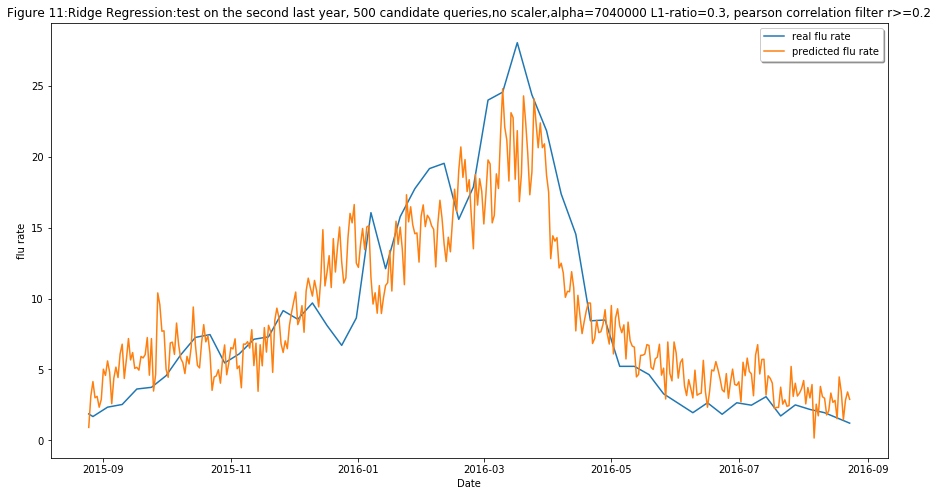

In [29]:
alpha=704000
ri = Ridge(alpha, copy_X=True, fit_intercept=True, max_iter=None,
  normalize=False, random_state=None, solver='auto', tol=0.001)

ri.fit(train4_X,train4_y)

y_pred2 = ri.predict(test2_X1)

# visualize
date = pd.date_range('20050824',periods=4383)
import matplotlib.dates as mdates
df = y.copy()
df['y'] = y.values

fig, ax = plt.subplots()
ax.plot(date[3653:4018],df.y[3653:4018],label='real flu rate')
ax.plot(date[3653:4018],y_pred2,label='predicted flu rate')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper right', shadow=True)
plt.title("Figure 11:Ridge Regression:test on the second last year, 500 candidate queries,no scaler,alpha=7040000 L1-ratio=0.3, pearson correlation filter r>=0.2")
plt.ylabel('flu rate')
plt.xlabel('Date')

plt.show()

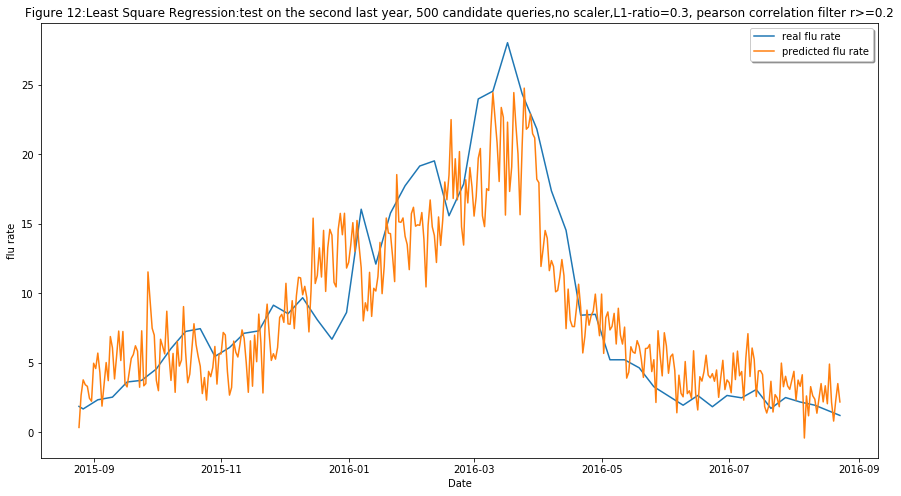

In [31]:
alpha=0
ri = Ridge(alpha, copy_X=True, fit_intercept=True, max_iter=None,
  normalize=False, random_state=None, solver='auto', tol=0.001)

ri.fit(train4_X,train4_y)

y_pred2 = ri.predict(test2_X1)

# visualize
date = pd.date_range('20050824',periods=4383)
import matplotlib.dates as mdates
df = y.copy()
df['y'] = y.values

fig, ax = plt.subplots()
ax.plot(date[3653:4018],df.y[3653:4018],label='real flu rate')
ax.plot(date[3653:4018],y_pred2,label='predicted flu rate')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper right', shadow=True)
plt.title("Figure 12:Least Square Regression:test on the second last year, 500 candidate queries,no scaler,L1-ratio=0.3, pearson correlation filter r>=0.2")
plt.ylabel('flu rate')
plt.xlabel('Date')

plt.show()